# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


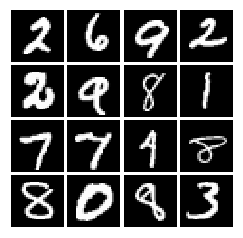

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, 0) - alpha * tf.maximum(-x, 0)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], -1, 1)


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        dense1 = tf.layers.dense(inputs=x, units=256)
        lrelu1 = leaky_relu(dense1, alpha=0.01)
        dense2 = tf.layers.dense(inputs=lrelu1, units=256)
        lrelu2 = leaky_relu(dense2, alpha=0.01)
        logits = tf.layers.dense(inputs=lrelu2, units=1)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        dense1 = tf.layers.dense(inputs=z, units=1024)
        relu1 = tf.nn.relu(dense1)
        dense2 = tf.layers.dense(inputs=relu1, units=1024)
        relu2 = tf.nn.relu(dense2)
        dense3 = tf.layers.dense(inputs=relu2, units=784)
        img = tf.nn.tanh(dense3)
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                labels=tf.ones_like(logits_real),\
                                logits=logits_real) +\
                            tf.nn.sigmoid_cross_entropy_with_logits(\
                                    labels=tf.zeros_like(logits_fake),\
                                    logits=logits_fake))
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
                                labels=tf.ones_like(logits_fake),\
                                logits=logits_fake))
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [22]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

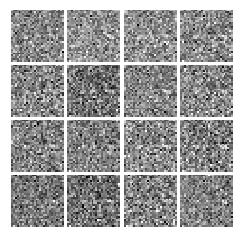


Iter: 0, D: 1.403, G:0.6883
Iter: 50, D: 0.2746, G:1.619
Iter: 100, D: 0.9754, G:1.252
Iter: 150, D: 1.205, G:2.079
Iter: 200, D: 1.721, G:0.7991


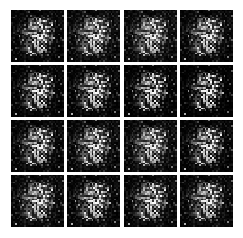


Iter: 250, D: 1.606, G:0.8375
Iter: 300, D: 1.388, G:1.194
Iter: 350, D: 1.33, G:1.924
Iter: 400, D: 1.492, G:1.161
Iter: 450, D: 1.304, G:0.8574


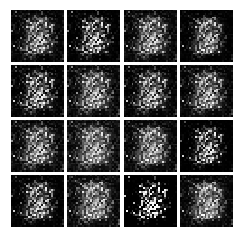


Iter: 500, D: 1.084, G:2.072
Iter: 550, D: 1.329, G:1.442
Iter: 600, D: 1.365, G:0.9943
Iter: 650, D: 1.125, G:1.156
Iter: 700, D: 1.334, G:1.39


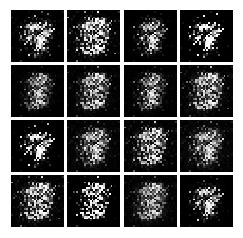


Iter: 750, D: 1.297, G:1.084
Iter: 800, D: 1.343, G:0.4799
Iter: 850, D: 1.017, G:1.087
Iter: 900, D: 1.229, G:1.113
Iter: 950, D: 1.18, G:1.074


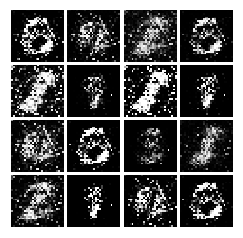


Iter: 1000, D: 1.3, G:3.523
Iter: 1050, D: 1.036, G:1.231
Iter: 1100, D: 1.288, G:1.015
Iter: 1150, D: 1.303, G:1.14
Iter: 1200, D: 0.9515, G:0.7697


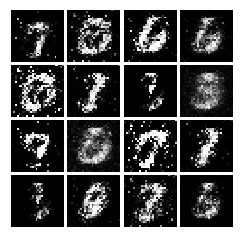


Iter: 1250, D: 1.397, G:0.9843
Iter: 1300, D: 1.394, G:0.7973
Iter: 1350, D: 1.263, G:1.034
Iter: 1400, D: 1.46, G:0.8136
Iter: 1450, D: 1.225, G:1.118


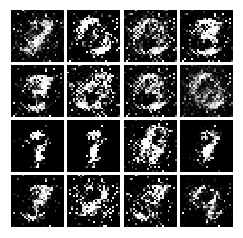


Iter: 1500, D: 1.094, G:1.568
Iter: 1550, D: 1.263, G:0.8168
Iter: 1600, D: 1.303, G:0.839
Iter: 1650, D: 1.229, G:0.991
Iter: 1700, D: 1.231, G:1.745


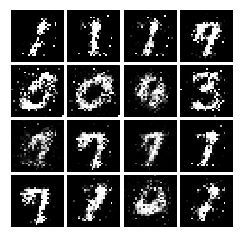


Iter: 1750, D: 1.3, G:0.8246
Iter: 1800, D: 1.422, G:0.7742
Iter: 1850, D: 1.336, G:0.8574
Iter: 1900, D: 1.339, G:0.8524
Iter: 1950, D: 1.297, G:0.8628


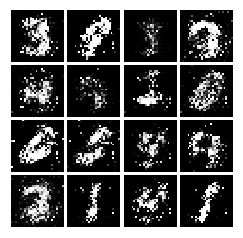


Iter: 2000, D: 1.377, G:0.9022
Iter: 2050, D: 1.365, G:0.9149
Iter: 2100, D: 1.325, G:0.8415
Iter: 2150, D: 1.325, G:0.9116
Iter: 2200, D: 1.349, G:0.7763


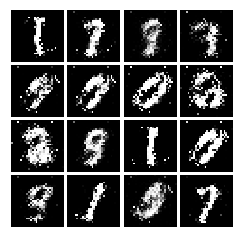


Iter: 2250, D: 1.29, G:0.7843
Iter: 2300, D: 1.345, G:0.8854
Iter: 2350, D: 1.307, G:1.072
Iter: 2400, D: 1.336, G:0.7902
Iter: 2450, D: 1.465, G:0.9379


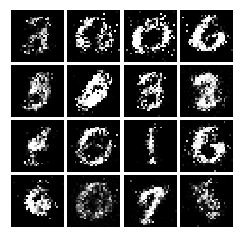


Iter: 2500, D: 1.295, G:0.796
Iter: 2550, D: 1.409, G:0.8462
Iter: 2600, D: 1.296, G:0.9367
Iter: 2650, D: 1.287, G:0.9023
Iter: 2700, D: 1.362, G:0.8122


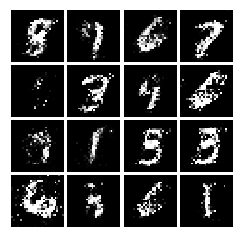


Iter: 2750, D: 1.268, G:0.7899
Iter: 2800, D: 1.282, G:0.8053
Iter: 2850, D: 1.313, G:0.8899
Iter: 2900, D: 1.343, G:0.8868
Iter: 2950, D: 1.346, G:0.8986


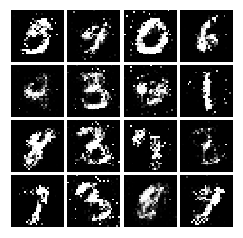


Iter: 3000, D: 1.347, G:0.7649
Iter: 3050, D: 1.257, G:0.8057
Iter: 3100, D: 1.293, G:0.7818
Iter: 3150, D: 1.327, G:0.7309
Iter: 3200, D: 1.366, G:0.7523


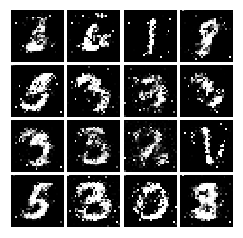


Iter: 3250, D: 1.36, G:0.8799
Iter: 3300, D: 1.335, G:0.8704
Iter: 3350, D: 1.395, G:0.7588
Iter: 3400, D: 1.308, G:0.887
Iter: 3450, D: 1.323, G:0.7234


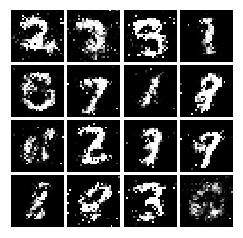


Iter: 3500, D: 1.386, G:0.7821
Iter: 3550, D: 1.317, G:0.8393
Iter: 3600, D: 1.328, G:0.796
Iter: 3650, D: 1.391, G:0.7814
Iter: 3700, D: 1.372, G:1.02


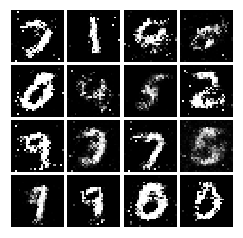


Iter: 3750, D: 1.317, G:0.7642
Iter: 3800, D: 1.304, G:0.7773
Iter: 3850, D: 1.397, G:0.8385
Iter: 3900, D: 1.355, G:0.7377
Iter: 3950, D: 1.331, G:0.7588


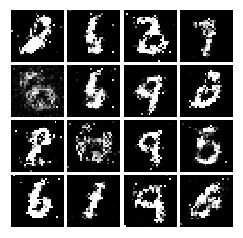


Iter: 4000, D: 1.302, G:0.846
Iter: 4050, D: 1.314, G:0.9368
Iter: 4100, D: 1.358, G:0.7818
Iter: 4150, D: 1.309, G:0.9834
Iter: 4200, D: 1.346, G:0.7026


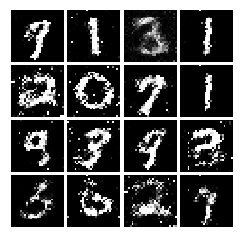


Iter: 4250, D: 1.376, G:0.7747
Final images


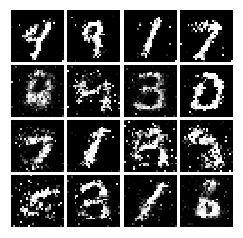

In [38]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [14]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = 1/2 * tf.reduce_mean((score_real - 1)**2) +\
             1/2 * tf.reduce_mean((score_fake)**2)
    G_loss = 1/2 * tf.reduce_mean((score_fake - 1)**2)
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [15]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [43]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

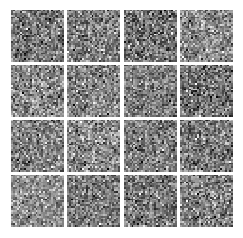


Iter: 0, D: 0.8683, G:0.3083
Iter: 50, D: 0.03251, G:0.7755
Iter: 100, D: 0.04823, G:0.7815
Iter: 150, D: 0.1417, G:0.6829
Iter: 200, D: 0.1173, G:0.3374


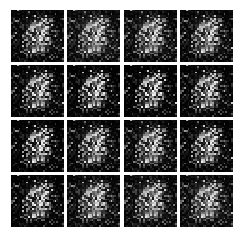


Iter: 250, D: 0.1837, G:0.4203
Iter: 300, D: 0.1309, G:0.5413
Iter: 350, D: 0.1077, G:0.357
Iter: 400, D: 0.3253, G:0.9303
Iter: 450, D: 0.08452, G:0.4168


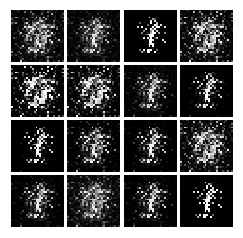


Iter: 500, D: 0.4088, G:0.9756
Iter: 550, D: 0.07935, G:0.4555
Iter: 600, D: 0.1562, G:1.15
Iter: 650, D: 0.17, G:0.4011
Iter: 700, D: 0.1328, G:0.3533


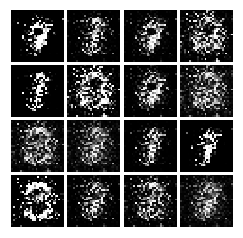


Iter: 750, D: 0.1127, G:0.4969
Iter: 800, D: 0.1685, G:0.3308
Iter: 850, D: 0.08268, G:0.4058
Iter: 900, D: 0.1608, G:0.6211
Iter: 950, D: 0.28, G:0.1796


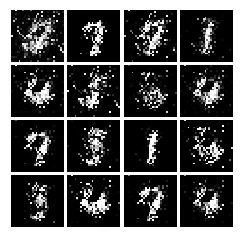


Iter: 1000, D: 0.179, G:0.2689
Iter: 1050, D: 0.1457, G:0.2734
Iter: 1100, D: 0.1838, G:0.3906
Iter: 1150, D: 0.2488, G:0.2158
Iter: 1200, D: 0.1614, G:0.3346


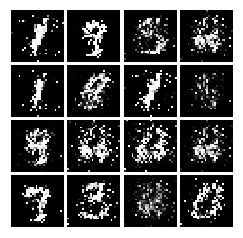


Iter: 1250, D: 0.1374, G:0.2783
Iter: 1300, D: 0.1923, G:0.2544
Iter: 1350, D: 0.185, G:0.2301
Iter: 1400, D: 0.1878, G:0.2507
Iter: 1450, D: 0.1684, G:0.2161


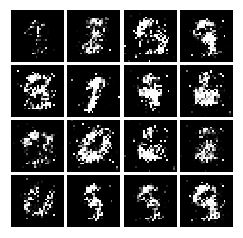


Iter: 1500, D: 0.1742, G:0.2188
Iter: 1550, D: 0.1905, G:0.1934
Iter: 1600, D: 0.1899, G:0.2142
Iter: 1650, D: 0.1991, G:0.2647
Iter: 1700, D: 0.2201, G:0.2564


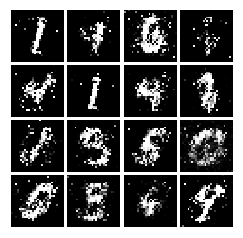


Iter: 1750, D: 0.1944, G:0.2028
Iter: 1800, D: 0.2047, G:0.1895
Iter: 1850, D: 0.2383, G:0.213
Iter: 1900, D: 0.2452, G:0.2624
Iter: 1950, D: 0.1906, G:0.1834


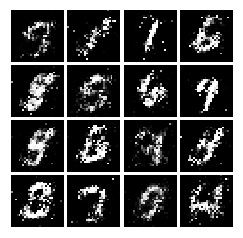


Iter: 2000, D: 0.2204, G:0.193
Iter: 2050, D: 0.212, G:0.1861
Iter: 2100, D: 0.2461, G:0.1888
Iter: 2150, D: 0.2176, G:0.1933
Iter: 2200, D: 0.208, G:0.1809


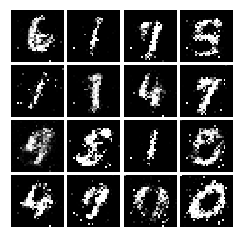


Iter: 2250, D: 0.1984, G:0.164
Iter: 2300, D: 0.1959, G:0.1837
Iter: 2350, D: 0.2412, G:0.2495
Iter: 2400, D: 0.2115, G:0.1731
Iter: 2450, D: 0.2025, G:0.1828


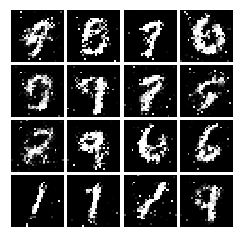


Iter: 2500, D: 0.2074, G:0.2021
Iter: 2550, D: 0.2136, G:0.1834
Iter: 2600, D: 0.2293, G:0.1835
Iter: 2650, D: 0.2049, G:0.178
Iter: 2700, D: 0.1835, G:0.1803


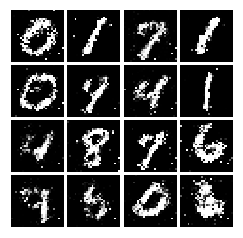


Iter: 2750, D: 0.2229, G:0.1516
Iter: 2800, D: 0.22, G:0.2081
Iter: 2850, D: 0.2272, G:0.2312
Iter: 2900, D: 0.2217, G:0.1886
Iter: 2950, D: 0.212, G:0.1642


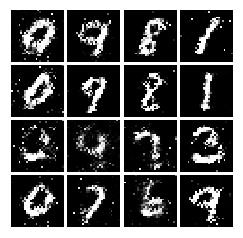


Iter: 3000, D: 0.2319, G:0.1611
Iter: 3050, D: 0.2103, G:0.1563
Iter: 3100, D: 0.2154, G:0.2013
Iter: 3150, D: 0.2172, G:0.1812
Iter: 3200, D: 0.2333, G:0.1664


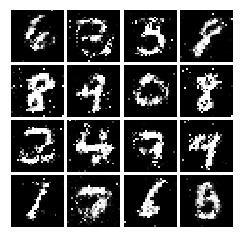


Iter: 3250, D: 0.2156, G:0.1636
Iter: 3300, D: 0.2249, G:0.1718
Iter: 3350, D: 0.2169, G:0.1557
Iter: 3400, D: 0.2179, G:0.1959
Iter: 3450, D: 0.2184, G:0.1701


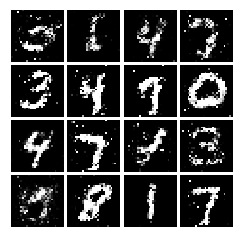


Iter: 3500, D: 0.2279, G:0.1764
Iter: 3550, D: 0.213, G:0.1828
Iter: 3600, D: 0.2199, G:0.1642
Iter: 3650, D: 0.2398, G:0.1902
Iter: 3700, D: 0.2272, G:0.1685


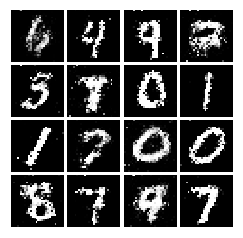


Iter: 3750, D: 0.2242, G:0.1571
Iter: 3800, D: 0.238, G:0.1821
Iter: 3850, D: 0.2109, G:0.1733
Iter: 3900, D: 0.2176, G:0.1762
Iter: 3950, D: 0.2212, G:0.1807


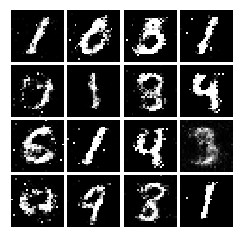


Iter: 4000, D: 0.2428, G:0.1732
Iter: 4050, D: 0.2227, G:0.1927
Iter: 4100, D: 0.2242, G:0.1764
Iter: 4150, D: 0.2203, G:0.1883
Iter: 4200, D: 0.2322, G:0.1852


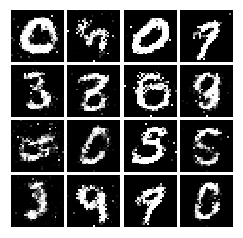


Iter: 4250, D: 0.2433, G:0.1859
Final images


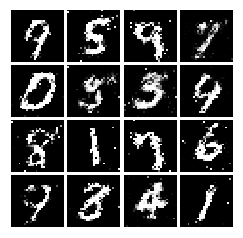

In [44]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [16]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x_reshaped = tf.reshape(x, shape=[-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(x_reshaped, 32, 5, activation=leaky_relu)
        mpool1 = tf.layers.max_pooling2d(conv1, 2, 2)
        conv2 = tf.layers.conv2d(mpool1, 64, 5, activation=leaky_relu)
        mpool2 = tf.layers.max_pooling2d(conv2, 2, 2)
        flatten = tf.layers.flatten(mpool2)
        dense1 = tf.layers.dense(flatten, 4*4*64, activation=leaky_relu)
        logits = tf.layers.dense(dense1, 1)
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [17]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        dense1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(dense1)
        dense2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(dense2)
        img_reshaped = tf.reshape(bn2, [-1, 7, 7, 128])
        trans_conv1 = tf.layers.conv2d_transpose(img_reshaped, 64, 4, 2, activation=tf.nn.relu, padding='same')
        bn3 = tf.layers.batch_normalization(trans_conv1)
        trans_conv2 = tf.layers.conv2d_transpose(bn3, 1, 4, 2, activation=tf.nn.tanh, padding='same')
        img = tf.reshape(trans_conv2, [-1, 784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [62]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

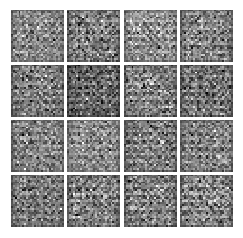


Iter: 0, D: 1.282, G:0.6664
Iter: 50, D: 0.3629, G:4.745
Iter: 100, D: 0.4739, G:3.094
Iter: 150, D: 1.265, G:2.875
Iter: 200, D: 0.3858, G:2.749


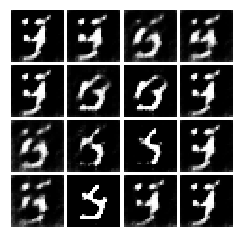


Iter: 250, D: 0.7128, G:1.642
Iter: 300, D: 0.6182, G:2.123
Iter: 350, D: 0.4622, G:3.002
Iter: 400, D: 0.6434, G:2.091
Iter: 450, D: 0.772, G:3.264


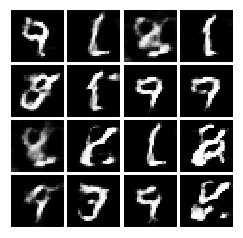


Iter: 500, D: 0.6179, G:2.098
Iter: 550, D: 0.6639, G:2.184
Iter: 600, D: 1.165, G:1.354
Iter: 650, D: 0.5344, G:1.979
Iter: 700, D: 0.9406, G:3.308


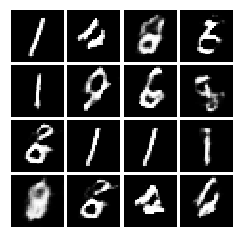


Iter: 750, D: 0.7621, G:1.034
Iter: 800, D: 0.5736, G:2.151
Iter: 850, D: 0.6061, G:2.017
Iter: 900, D: 0.6327, G:1.742
Iter: 950, D: 0.6401, G:1.517


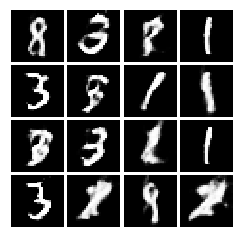


Iter: 1000, D: 0.6053, G:1.854
Iter: 1050, D: 0.5928, G:1.813
Iter: 1100, D: 0.5764, G:1.934
Iter: 1150, D: 0.6798, G:1.682
Iter: 1200, D: 0.689, G:1.962


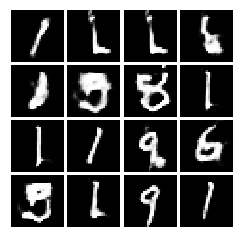


Iter: 1250, D: 0.5873, G:1.665
Iter: 1300, D: 0.7383, G:1.897
Iter: 1350, D: 0.6002, G:2.138
Iter: 1400, D: 0.5761, G:1.647
Iter: 1450, D: 0.6275, G:1.86


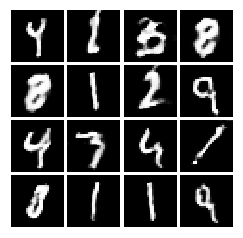


Iter: 1500, D: 0.5999, G:2.194
Iter: 1550, D: 1.176, G:4.239
Iter: 1600, D: 0.7592, G:1.182
Iter: 1650, D: 0.6959, G:2.571
Iter: 1700, D: 0.6524, G:1.822


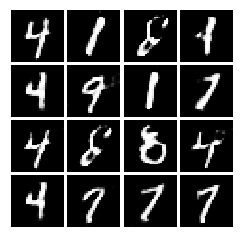


Iter: 1750, D: 0.6674, G:1.223
Iter: 1800, D: 0.7559, G:2.291
Iter: 1850, D: 0.6969, G:1.916
Iter: 1900, D: 0.6196, G:2.154
Iter: 1950, D: 0.595, G:2.002


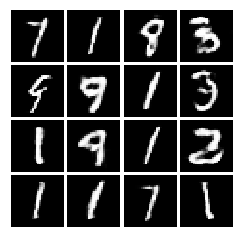


Iter: 2000, D: 0.8523, G:2.16
Iter: 2050, D: 0.6741, G:1.829
Iter: 2100, D: 0.6384, G:2.106
Final images


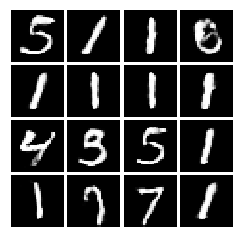

In [65]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here: InfoGAN

In [9]:
categorical_code_dim = 10
continuous_code_dim = 2

In [10]:
def generator(z, categorical_code, continuous_code):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    - categorical_code: TensorFlow Tensor of random noise with shape [batch_size, categorical_code_dim]
    - continuous_code: TensorFlow Tensor of random noise with shape [batch_size, continuous_code_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope('generator'):
        inputs = tf.concat([z, categorical_code, continuous_code], 1)
        dense1 = tf.layers.dense(inputs, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(dense1)
        dense2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(dense2)
        img_reshaped = tf.reshape(bn2, [-1, 7, 7, 128])
        trans_conv1 = tf.layers.conv2d_transpose(img_reshaped, 64, 4, 2, activation=tf.nn.relu, padding='same')
        bn3 = tf.layers.batch_normalization(trans_conv1)
        trans_conv2 = tf.layers.conv2d_transpose(bn3, 1, 4, 2, activation=tf.nn.tanh, padding='same')
        img = tf.reshape(trans_conv2, [-1, 784])

        return img

In [11]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    - logits: TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    - bn: TensorFlow Tensor with shape [batch_size, 1024], containing the input
    of recognition_network
    """
    with tf.variable_scope("discriminator"):
        x_reshaped = tf.reshape(x, shape=[-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(x_reshaped, 64, 4, 2, activation=leaky_relu)
        conv2 = tf.layers.conv2d(conv1, 128, 4, 2, activation=leaky_relu)
        bn1 = tf.layers.batch_normalization(conv2)
        flatten = tf.layers.flatten(bn1)
        dense1 = tf.layers.dense(flatten, 1024, activation=leaky_relu)
        bn2 = tf.layers.batch_normalization(dense1)
        logits = tf.layers.dense(bn2, 1)
        return (logits, bn2)

In [12]:
def recognition_network(x):
    """Compute categorical / continuous codes for a batch of input vectors.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input vectors, shape [batch_size, 1024]
    
    Returns:
    - codes: TensorFlow Tensor with shape [batch_size, categorical_code_dim+continuous_code_dim]
    """
    with tf.variable_scope("recognition_network"):
        dense1 = tf.layers.dense(x, 128)
        bn1 = tf.layers.batch_normalization(dense1)
        codes = tf.layers.dense(leaky_relu(bn1), categorical_code_dim+continuous_code_dim)
        return codes

In [13]:
def mutual_information_loss(cat_real, con_real, gen_codes, lam=1.0):
    """ Compute the loss for latent codes: categorical codes and continuous codes.
    
    Inputs:
    - cat_real: TensorFlow Tensor of real categorical codes, shape [batch_size, categorical_code_dim]
    - con_real: TensorFlow Tensor of real continuous codes, shape [batch_size, continuous_code_dim]
    - gen_codes: TensorFlow Tensor of latent codes, shape [batch_size, categorical_code_dim + continuous_code_dim]
    - lam: Scaler for latent code loss, float
    
    Returns:
    - latent codes loss scalar
    """
    loss_cat = tf.losses.softmax_cross_entropy(cat_real, gen_codes[:, :categorical_code_dim])
    loss_con = tf.losses.mean_squared_error(con_real, gen_codes[:, categorical_code_dim:])
    return lam * (loss_cat + loss_con)

In [83]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 62

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = tf.placeholder(tf.float32, [None, noise_dim])
categorical_code = tf.placeholder(tf.float32, [None, categorical_code_dim])
continuous_code = tf.placeholder(tf.float32, [None, continuous_code_dim])

# generated images
G_sample = generator(z, categorical_code, continuous_code)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real, _ = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake, recog_inputs = discriminator(G_sample)

codes = recognition_network(recog_inputs)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 
Q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

# get our solver
D_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5)
G_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5)
Q_solver = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=0.5)

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)
Q_loss = mutual_information_loss(categorical_code, continuous_code, codes)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
Q_train_step = Q_solver.minimize(Q_loss, var_list=Q_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')
Q_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [84]:
def sample_code(batch_size, categorical_code_dim, continuous_code_dim, for_plotting=False):
    """Generate sample code: categorical code, continuous code
    
    Args:
    - batch_size
    - categorical_code_dim
    - continuous_code_dim
    - for_plotting: if true, it makes fixed continuous code for plotting.
    
    Returns:
    - cat: one-hot vetors for categorical code, shape [batch_size, categorical_code_dim]
    - con: float values [-1, 1], shape [batch_size, continuous_code_dim]
    """
    # generate categorical and continuous codes
    if not for_plotting:
        cat = np.random.multinomial(1, [1/categorical_code_dim]*categorical_code_dim, size=[batch_size])
        con = np.random.uniform(low=-1., high=1., size=[batch_size, continuous_code_dim])
    else:
        cat_codes = np.random.randint(categorical_code_dim, size=continuous_code_dim)
        cat = np.zeros([batch_size, categorical_code_dim])
        for i, cat_code in list(enumerate(cat_codes)):
            cat[i*categorical_code_dim:(i+1)*categorical_code_dim, cat_code] = 1
        for i in range(categorical_code_dim):
            cat[(continuous_code_dim*categorical_code_dim)+i, i] = 1
        cat[(continuous_code_dim+1)*categorical_code_dim:, 0] = 1
        
        con = np.zeros([batch_size, continuous_code_dim])
        linspace = np.linspace(-2., 2., num=categorical_code_dim)
        for i in range(continuous_code_dim):
            con[i*categorical_code_dim:(i+1)*categorical_code_dim, i] = linspace
            print('row',i,': continuouse code',i,'changes, otherwise fixed. categorical_code: ', cat_codes[i])
        
        print('last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left')
    return (cat, con)

In [85]:
def sample_noise(noise_dim, batch_size, for_plotting=False):
    """Generate sample noise
    
    Args:
    - noise_dim: input noise dim for generator, int
    - batch_size: batch size, int
    - for_plotting: if true, it makes fixed noise for plotting.
    
    Returns:
    noise vector, shape [noise_dim, batch_size]
    """
    if not for_plotting:
        z = np.random.uniform(low=-1., high=1., size=[batch_size, noise_dim])
    else:
        noise = np.random.uniform(low=-1., high=1., size=[noise_dim])
        z = np.vstack([noise]*batch_size)
    return z

In [86]:
def show_images(samples):
    images = []
    for i in range(continuous_code_dim+1):
        image = samples[i*categorical_code_dim:(i+1)*categorical_code_dim, :]
        image = image.reshape([categorical_code_dim, 28, 28])
        image = image.swapaxes(0, 1)
        image = image.reshape([28, categorical_code_dim*28])
        images.append(image)
    
    print_images = np.concatenate(images, axis=0)  

    plt.figure(figsize=(10, continuous_code_dim+1))
    plt.axis('off')
    plt.imshow(print_images, cmap='gray')
    plt.show()

In [87]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, Q_train_step, Q_loss,\
              G_extra_step, D_extra_step, Q_extra_step,\
              show_every=1000, print_every=200, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Discriminator
    - D_loss: Discriminator loss
    - Q_train_step: A training step for the codes
    - Q_loss: Recognition network loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    - Q_extra_step: A collection of tf.GraphKeys.UPDATE_OPS
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            noise = sample_noise(noise_dim, batch_size, True)
            cat, con = sample_code(batch_size, categorical_code_dim, continuous_code_dim, True)
            samples = sess.run(G_sample, feed_dict={z:noise,\
                                                    categorical_code:cat,\
                                                    continuous_code:con})
            fig = show_images(samples[:categorical_code_dim*(continuous_code_dim+1)])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        noise = sample_noise(noise_dim, batch_size)
        cat, con = sample_code(batch_size, categorical_code_dim, continuous_code_dim)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={z:noise,\
                                                                     x:minibatch,\
                                                                     categorical_code:cat,\
                                                                     continuous_code:con})
        noise = sample_noise(noise_dim, batch_size)
        cat, con = sample_code(batch_size, categorical_code_dim, continuous_code_dim)
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={z:noise,\
                                                                     categorical_code:cat,\
                                                                     continuous_code:con})
        noise = sample_noise(noise_dim, batch_size)
        cat, con = sample_code(batch_size, categorical_code_dim, continuous_code_dim)
        _, Q_loss_curr = sess.run([Q_train_step, Q_loss], feed_dict={z:noise,\
                                                                     categorical_code:cat,\
                                                                     continuous_code:con})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter:{}, D:{:.4}, G:{:.4}, Q:{:.4}'.format(it,D_loss_curr,G_loss_curr,Q_loss_curr))
    print('Final images')
    noise = sample_noise(noise_dim, batch_size, True)
    cat, con = sample_code(batch_size, categorical_code_dim, continuous_code_dim, True)
    samples = sess.run(G_sample, feed_dict={z:noise,
                                            categorical_code:cat,\
                                            continuous_code:con})

    fig = show_images(samples[:categorical_code_dim*(continuous_code_dim+1)])
    plt.show()

row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  3
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  9
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


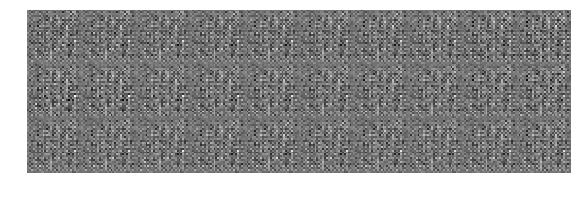


Iter:0, D:1.363, G:0.6938, Q:2.613
Iter:200, D:0.137, G:13.86, Q:2.612
Iter:400, D:0.03562, G:5.057, Q:2.615
Iter:600, D:0.002372, G:7.256, Q:2.637
Iter:800, D:0.04907, G:8.111, Q:2.642
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  5
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  1
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


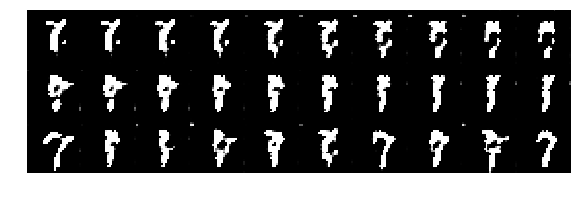


Iter:1000, D:0.2271, G:8.464, Q:0.451
Iter:1200, D:0.6038, G:4.907, Q:0.06996
Iter:1400, D:0.4722, G:2.691, Q:0.07625
Iter:1600, D:0.4631, G:2.52, Q:0.04033
Iter:1800, D:0.5491, G:2.326, Q:0.03747
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  1
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  3
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


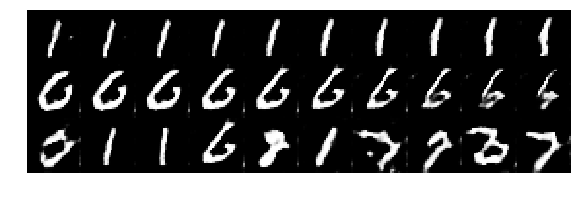


Iter:2000, D:0.9009, G:2.255, Q:0.05089
Iter:2200, D:0.8944, G:2.791, Q:0.09133
Iter:2400, D:0.7925, G:1.834, Q:0.03013
Iter:2600, D:0.6592, G:2.348, Q:0.03597
Iter:2800, D:0.7679, G:1.613, Q:0.04689
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  5
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  3
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


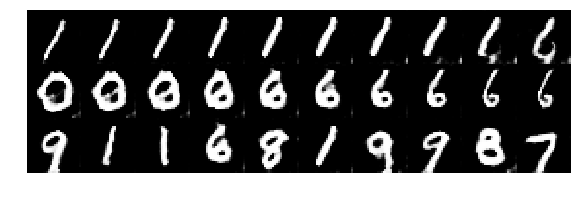


Iter:3000, D:0.7844, G:1.222, Q:0.02754
Iter:3200, D:0.7845, G:1.666, Q:0.02051
Iter:3400, D:1.02, G:2.037, Q:0.07609
Iter:3600, D:0.804, G:1.377, Q:0.03062
Iter:3800, D:0.8267, G:1.611, Q:0.03006
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  0
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  8
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


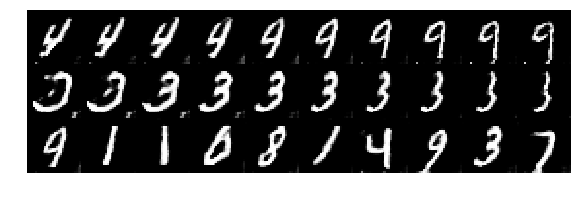


Iter:4000, D:0.7868, G:2.0, Q:0.01931
Iter:4200, D:0.8412, G:1.99, Q:0.06051
Iter:4400, D:0.8293, G:1.136, Q:0.02878
Iter:4600, D:0.9385, G:2.763, Q:0.0535
Iter:4800, D:0.8126, G:2.227, Q:0.0187
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  0
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  2
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


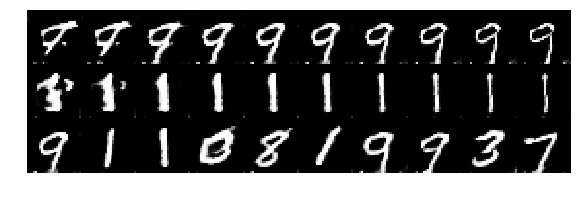


Iter:5000, D:0.7442, G:1.604, Q:0.0213
Iter:5200, D:0.7638, G:1.965, Q:0.02816
Iter:5400, D:0.6691, G:1.851, Q:0.02141
Iter:5600, D:0.7658, G:1.656, Q:0.04391
Iter:5800, D:0.8753, G:1.258, Q:0.01561
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  3
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  9
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


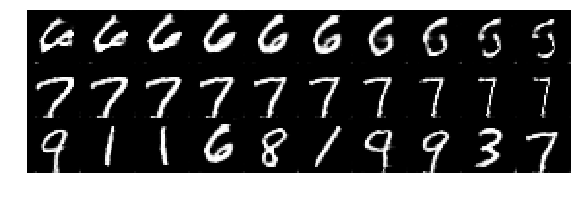


Iter:6000, D:0.7851, G:1.568, Q:0.01665
Iter:6200, D:0.7982, G:1.976, Q:0.01939
Iter:6400, D:0.6932, G:1.713, Q:0.04645
Iter:6600, D:0.7987, G:1.884, Q:0.01347
Iter:6800, D:0.9089, G:1.209, Q:0.02014
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  6
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  4
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


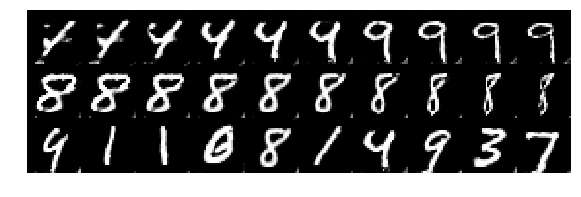


Iter:7000, D:0.7374, G:1.878, Q:0.03953
Iter:7200, D:0.8608, G:2.004, Q:0.01686
Iter:7400, D:0.6311, G:2.646, Q:0.01976
Iter:7600, D:0.7489, G:1.686, Q:0.01853
Iter:7800, D:0.7142, G:1.719, Q:0.01569
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  1
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  3
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


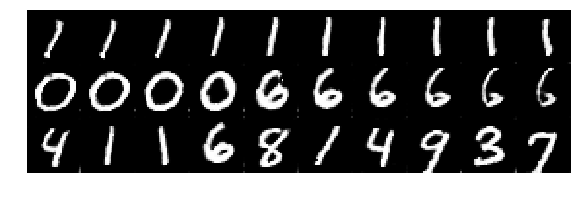


Iter:8000, D:0.7275, G:1.647, Q:0.01869
Iter:8200, D:0.7422, G:1.671, Q:0.03779
Iter:8400, D:0.7477, G:2.264, Q:0.06035
Final images
row 0 : continuouse code 0 changes, otherwise fixed. categorical_code:  4
row 1 : continuouse code 1 changes, otherwise fixed. categorical_code:  3
last row: all continuous codes are fixed, categorical code: 0 to categorical_code_dim from left


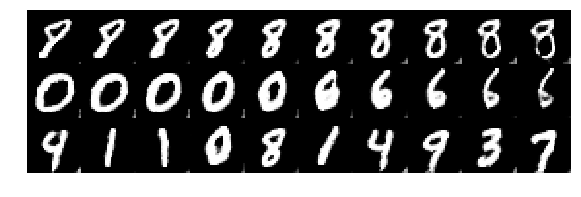

In [88]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,Q_train_step,Q_loss,G_extra_step,D_extra_step,Q_extra_step,num_epoch=20)

# WGAN-GP (Small Extra Credit)

#### !!Please skip InfoGAN to run WGAN-GP code!!

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [18]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        x_reshaped = tf.reshape(x, shape=[-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(x_reshaped, 64, 4, 2, activation=leaky_relu)
        conv2 = tf.layers.conv2d(conv1, 128, 4, 2, activation=leaky_relu)
        bn1 = tf.layers.batch_normalization(conv2)
        flatten = tf.layers.flatten(bn1)
        dense1 = tf.layers.dense(flatten, 1024, activation=leaky_relu)
        logits = tf.layers.dense(dense1, 1)
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [19]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [20]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
    x_hat = eps * x + (1 - eps) * G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat[0], axis=1, ord='euclidean')
    grad_pen = lam * tf.reduce_mean(tf.square(grad_norm - 1))
    D_loss += grad_pen

    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

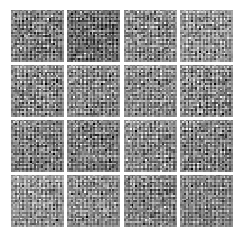


Iter: 0, D: 8.37, G:-0.02939
Iter: 50, D: -21.01, G:2.106
Iter: 100, D: -17.38, G:2.063
Iter: 150, D: -9.745, G:-7.967
Iter: 200, D: -5.413, G:9.703


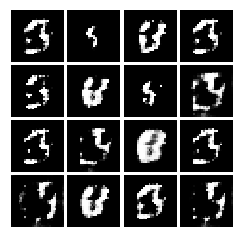


Iter: 250, D: -4.378, G:-1.071
Iter: 300, D: -6.951, G:-19.3
Iter: 350, D: -5.181, G:1.52
Iter: 400, D: -4.443, G:8.305
Iter: 450, D: -3.435, G:8.759


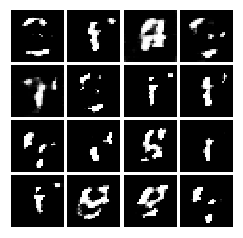


Iter: 500, D: -2.659, G:5.305
Iter: 550, D: -4.566, G:10.46
Iter: 600, D: -3.611, G:7.573
Iter: 650, D: -3.211, G:6.077
Iter: 700, D: -3.445, G:-1.691


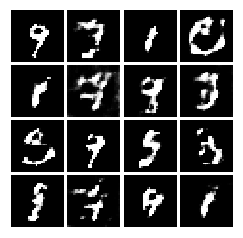


Iter: 750, D: -1.092, G:3.364
Iter: 800, D: -1.392, G:2.827
Iter: 850, D: -1.953, G:3.141
Iter: 900, D: -2.095, G:2.822
Iter: 950, D: -2.022, G:0.1672


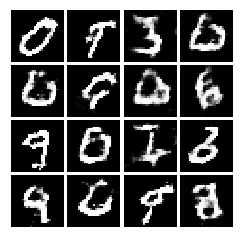


Iter: 1000, D: -1.374, G:0.2194
Iter: 1050, D: -1.562, G:2.366
Iter: 1100, D: -1.843, G:0.5909
Iter: 1150, D: -0.9545, G:-0.9145
Iter: 1200, D: -1.509, G:-2.867


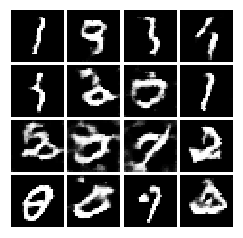


Iter: 1250, D: 0.4634, G:-0.1071
Iter: 1300, D: -1.129, G:2.142
Iter: 1350, D: -0.7016, G:-1.318
Iter: 1400, D: -0.2227, G:-0.7258
Iter: 1450, D: -0.3264, G:8.001


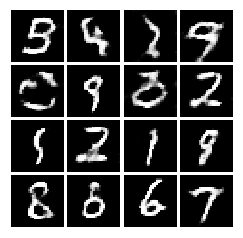


Iter: 1500, D: 0.6839, G:1.711
Iter: 1550, D: -0.1563, G:-2.278
Iter: 1600, D: -0.1548, G:-6.002
Iter: 1650, D: -0.7317, G:0.2653
Iter: 1700, D: -0.4697, G:-0.2412


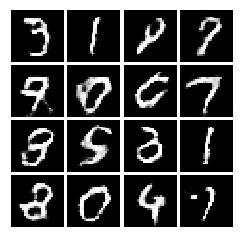


Iter: 1750, D: -0.7948, G:-1.535
Iter: 1800, D: -0.6246, G:-2.921
Iter: 1850, D: -0.6743, G:-3.72
Iter: 1900, D: -0.09355, G:-1.676
Iter: 1950, D: -0.3349, G:4.383


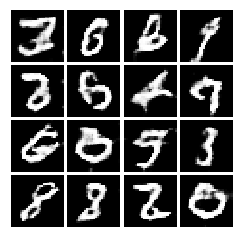


Iter: 2000, D: -0.2966, G:-2.118
Iter: 2050, D: -0.8551, G:3.788
Iter: 2100, D: -1.172, G:-0.8369
Final images


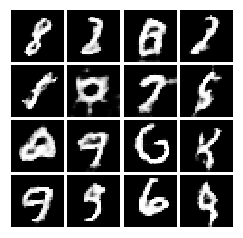

In [23]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)